# Clothing Segmentation Script

This script performs clothing segmentation on images using a pre-trained U-Net model with an EfficientNet-B3 encoder.

## Import Libraries

The script starts by importing necessary libraries for image processing, deep learning, and visualization.

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image
import cv2
from collections import namedtuple
from torch import nn
from torch.utils import model_zoo
from iglovikov_helper_functions.dl.pytorch.utils import rename_layers
from segmentation_models_pytorch import Unet

## Set Device

It checks for GPU availability and sets the device accordingly. This ensures the script can utilize GPU acceleration if available.

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Model Definition

A named tuple and dictionary are used to define the model architecture and pre-trained weights URL. This structure allows for easy expansion to include multiple models in the future.

In [28]:
model = namedtuple("model", ["url", "model"])

# Dictionary of available models
models = {
    "Unet_2020-10-30": model(
        # URL for downloading pre-trained weights
        url="https://github.com/ternaus/cloths_segmentation/releases/download/0.0.1/weights.zip",
        # Model architecture: U-Net with EfficientNet-B3 encoder
        model=Unet(encoder_name="timm-efficientnet-b3", classes=1, encoder_weights=None),
    )
}

## Create Model Function

This function downloads pre-trained weights, loads them into the model architecture, and returns the initialized model ready for use.

In [29]:
def create_model(model_name: str) -> nn.Module:
    # Get the model architecture
    model = models[model_name].model

    # Download and load the pre-trained weights
    state_dict = model_zoo.load_url(models[model_name].url, progress=True, map_location="cpu")["state_dict"]

    # Rename layers to match the model's layer names
    state_dict = rename_layers(state_dict, {"model.": ""})

    # Load the pre-trained weights into the model
    model.load_state_dict(state_dict)

    return model

# Initialize the model

In [30]:
model = create_model("Unet_2020-10-30").to(device)
model.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Swish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNormAct2d(
            40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Swish()
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False

## Image Preprocessing

The `preprocess_image` function prepares input images for the model by resizing, converting to tensor, and normalizing.

In [31]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image)
    return input_tensor.unsqueeze(0).to(device)

## Output Postprocessing

`postprocess_output` converts the model's output into a binary mask, which is then colorized for visualization.

In [32]:
def postprocess_output(output):
    output = output.squeeze().cpu().detach().numpy()
    output = (output > 0.5).astype(np.uint8) * 255
    colored_mask = np.zeros((output.shape[0], output.shape[1], 3), dtype=np.uint8)
    colored_mask[output == 255] = [255, 255, 255]  # White for clothing
    return colored_mask

## Segmentation Refinement

The `refine_segmentation` function uses edge detection and morphological operations to improve the quality of the segmentation mask.

In [33]:
def refine_segmentation(segmentation):
    gray = cv2.cvtColor(segmentation, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    kernel = np.ones((3,3), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)
    refined = cv2.bitwise_and(segmentation, segmentation, mask=255-dilated_edges)
    closing = cv2.morphologyEx(refined, cv2.MORPH_CLOSE, kernel)
    return closing

## Clothing Segmentation

`segment_clothing` combines preprocessing, model inference, and postprocessing to generate a refined segmentation mask for an input image.

In [34]:
def segment_clothing(image_path):
    input_tensor = preprocess_image(image_path)
    
    with torch.no_grad():
        output = model(input_tensor)
    
    mask = postprocess_output(output)
    refined_mask = refine_segmentation(mask)
    return refined_mask

## Clothing Extraction

`extract_clothing` uses the segmentation mask to isolate the clothing item from the original image, placing it on a white background.

In [35]:
def extract_clothing(original_image, mask):
    # Convert mask to binary (0 or 255)
    binary_mask = (mask[:,:,0] > 0).astype(np.uint8) * 255
    
    # Create a white background
    white_background = np.ones_like(original_image) * 255
    
    # Use the binary mask to combine the original image and white background
    extracted_clothing = np.where(binary_mask[:,:,np.newaxis] == 255, original_image, white_background)
    
    return Image.fromarray(extracted_clothing.astype(np.uint8))

## Batch Processing

The `process_images` function applies the segmentation pipeline to multiple images, saving and displaying the results.

In [36]:
def process_images(image_paths, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for i, img_path in enumerate(image_paths):
        # Load and preprocess the image
        original_image = Image.open(img_path).convert("RGB")
        original_image = original_image.resize((320, 320))
        
        # Segment the clothing
        mask = segment_clothing(img_path)
        
        # Extract the clothing
        extracted_clothing = extract_clothing(np.array(original_image), mask)
        
        # Apply the mask to the original image
        masked_image = cv2.addWeighted(np.array(original_image), 0.7, mask, 0.3, 0)
        
        # Save the results
        original_image.save(os.path.join(output_dir, f"original_{i+1}.png"))
        Image.fromarray(mask).save(os.path.join(output_dir, f"mask_{i+1}.png"))
        Image.fromarray(masked_image).save(os.path.join(output_dir, f"masked_{i+1}.png"))
        extracted_clothing.save(os.path.join(output_dir, f"extracted_{i+1}.png"))
        
        # Display the results
        plt.figure(figsize=(20, 5))
        plt.subplot(141)
        plt.imshow(original_image)
        plt.title(f"Original Image {i+1}")
        plt.axis('off')
        
        plt.subplot(142)
        plt.imshow(mask)
        plt.title(f"Segmentation Mask {i+1}")
        plt.axis('off')
        
        plt.subplot(143)
        plt.imshow(masked_image)
        plt.title(f"Masked Image {i+1}")
        plt.axis('off')
        
        plt.subplot(144)
        plt.imshow(extracted_clothing)
        plt.title(f"Extracted Clothing {i+1}")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

    print("Segmentation results saved in:", output_dir)

## Main Execution

The script concludes with a main execution block that processes a list of input images and saves the results to a specified output directory.

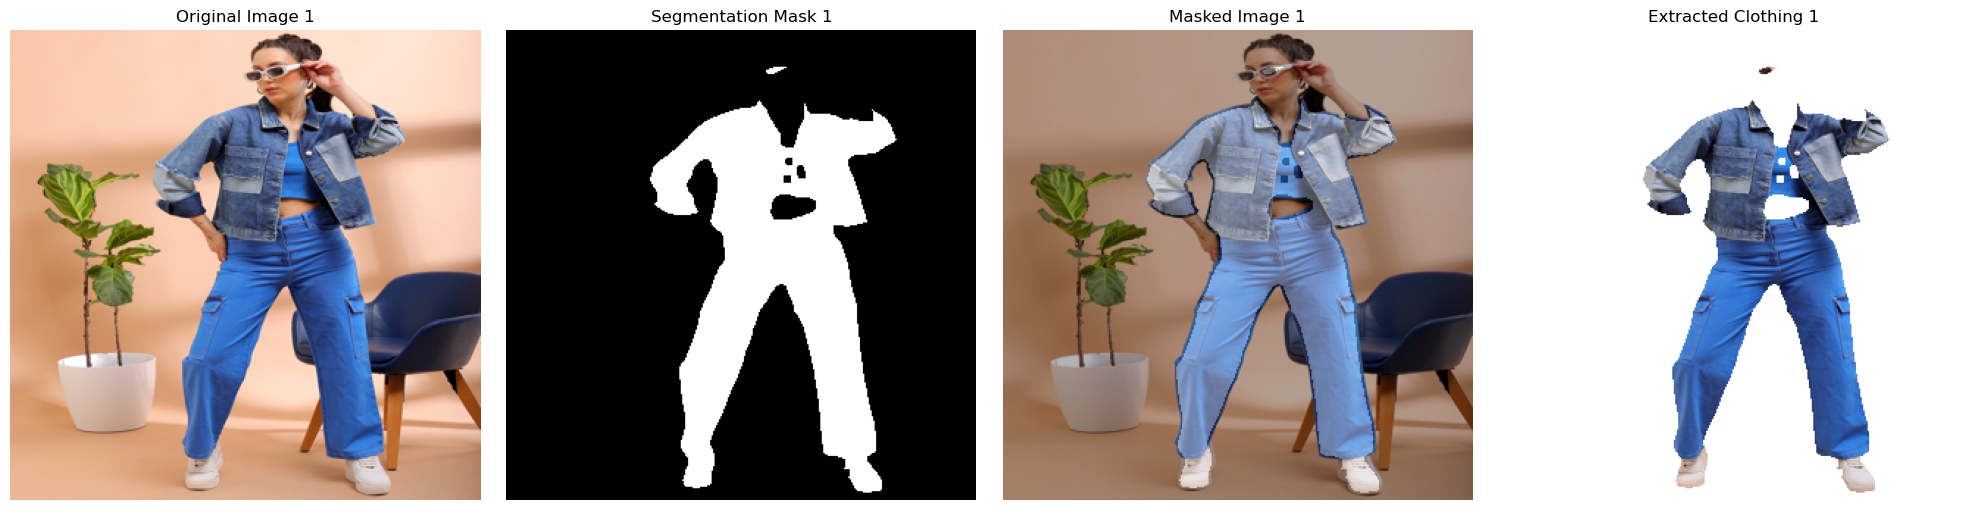

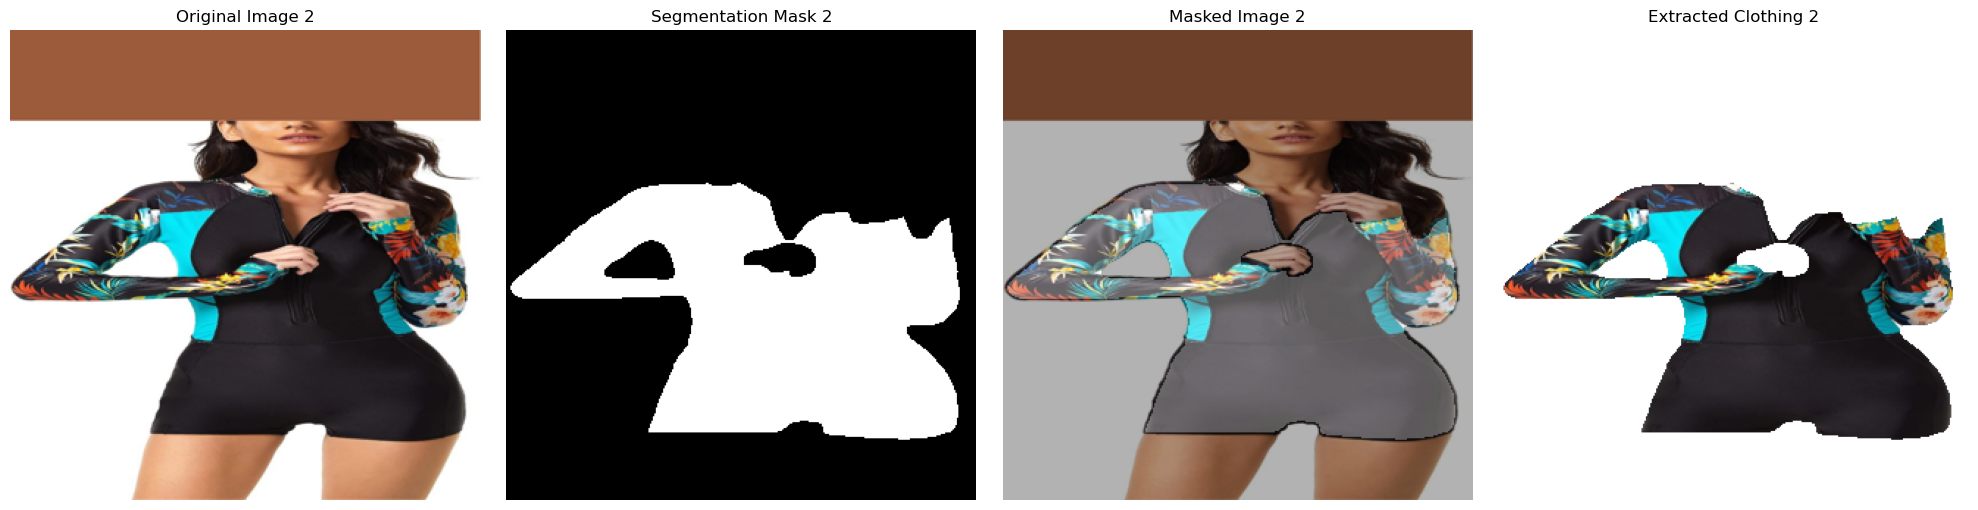

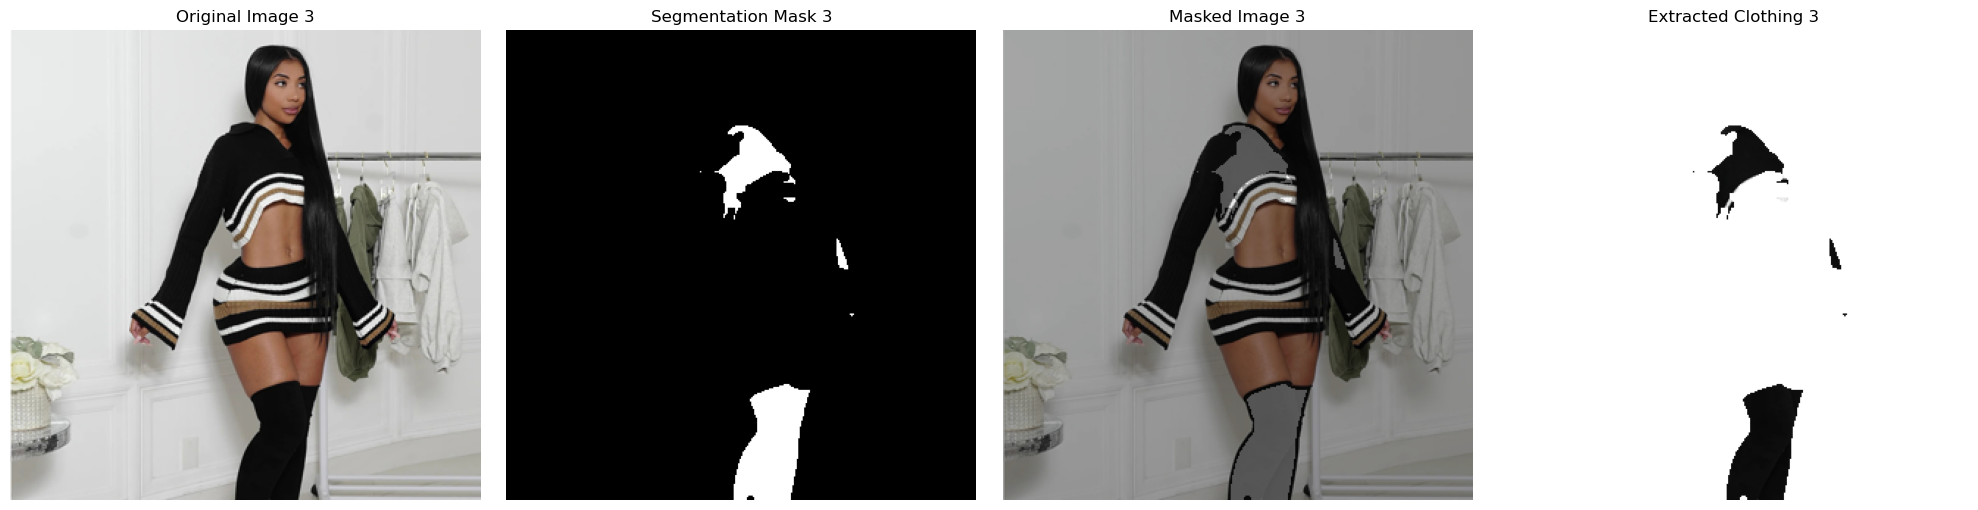

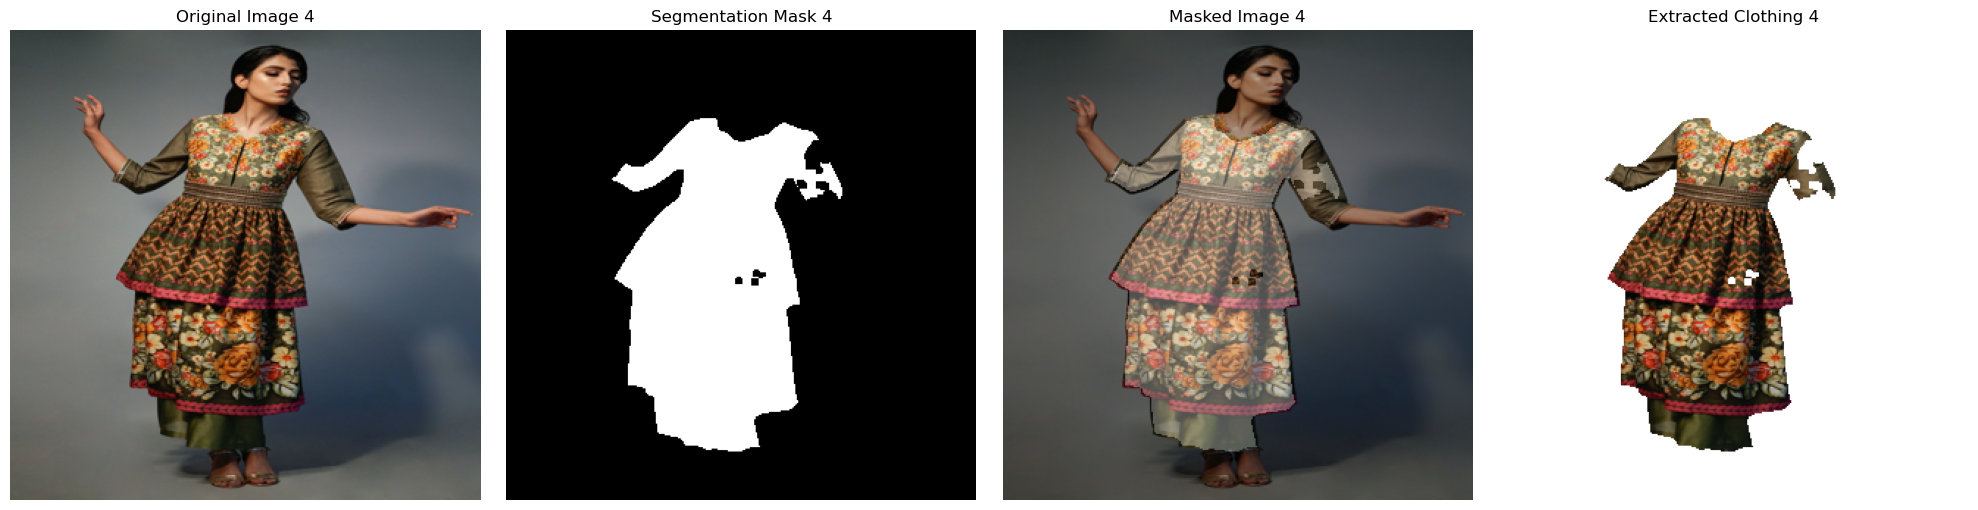

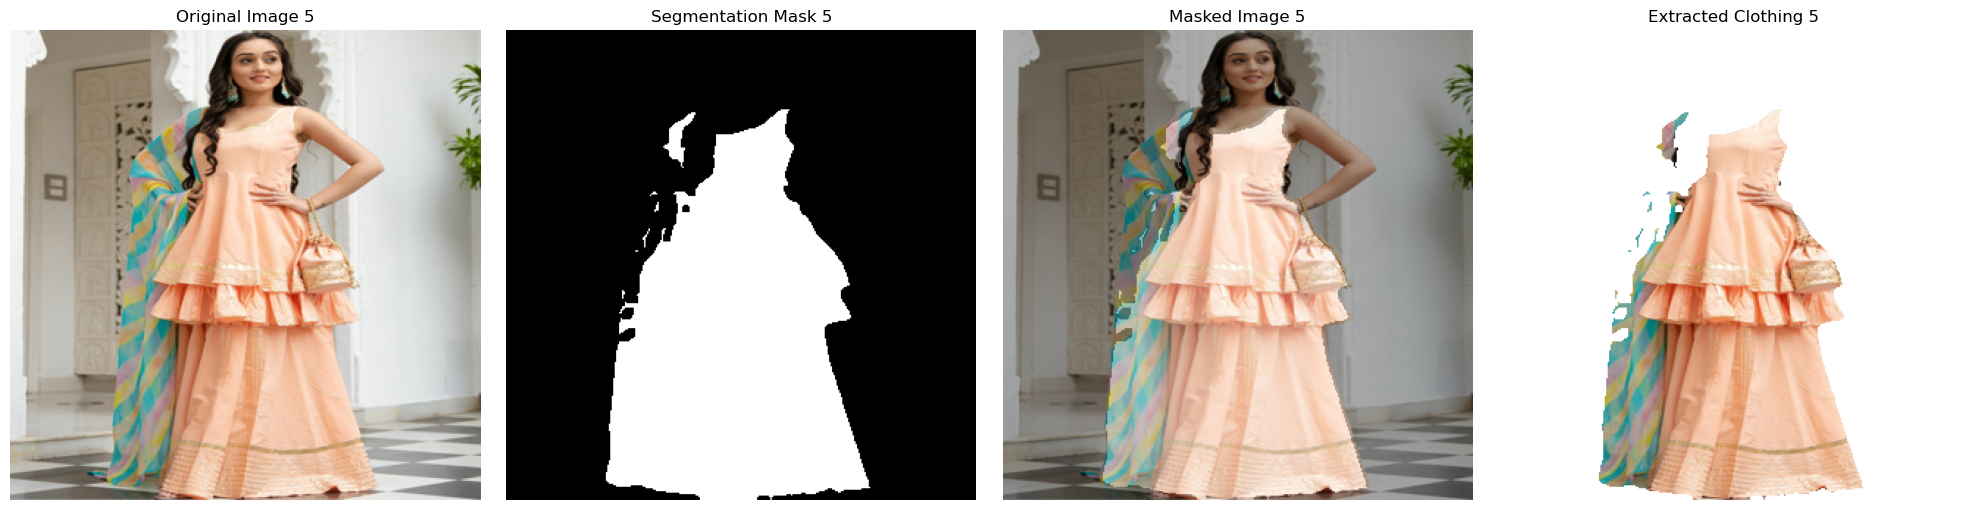

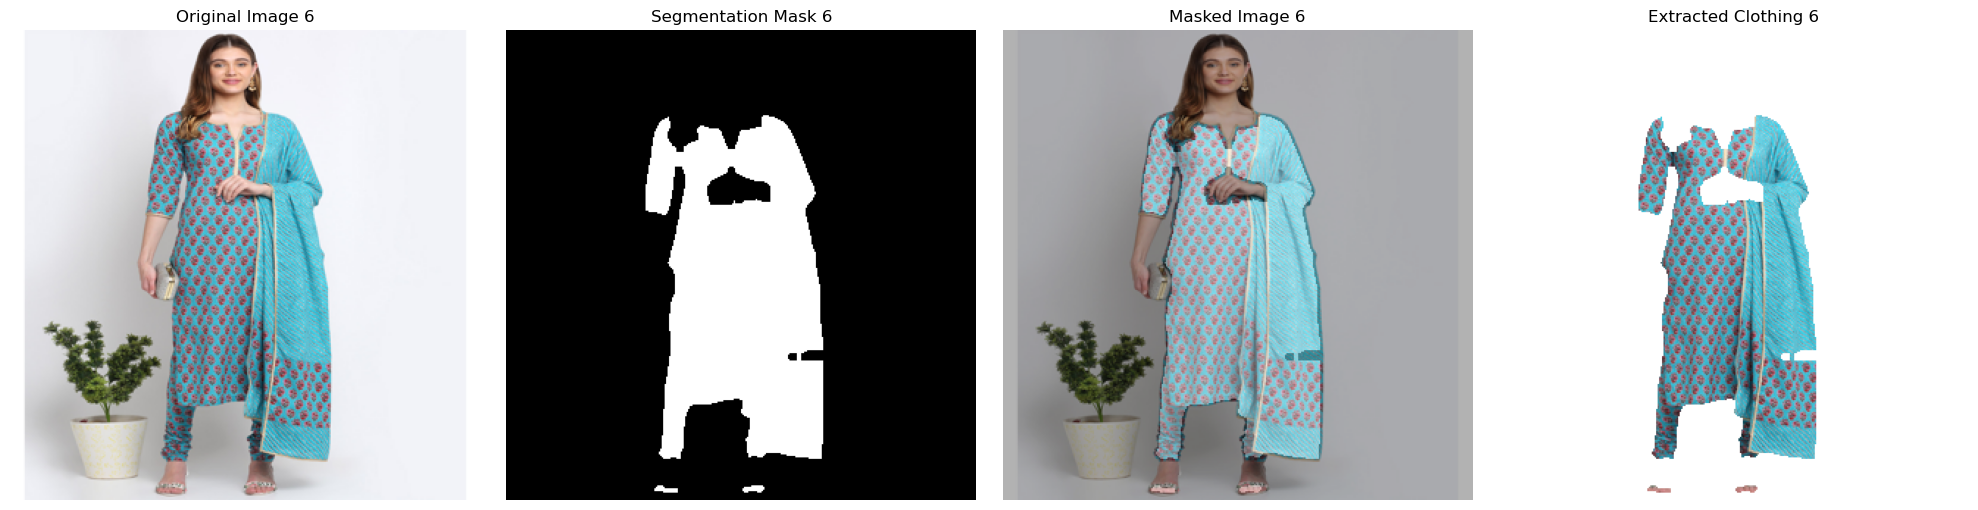

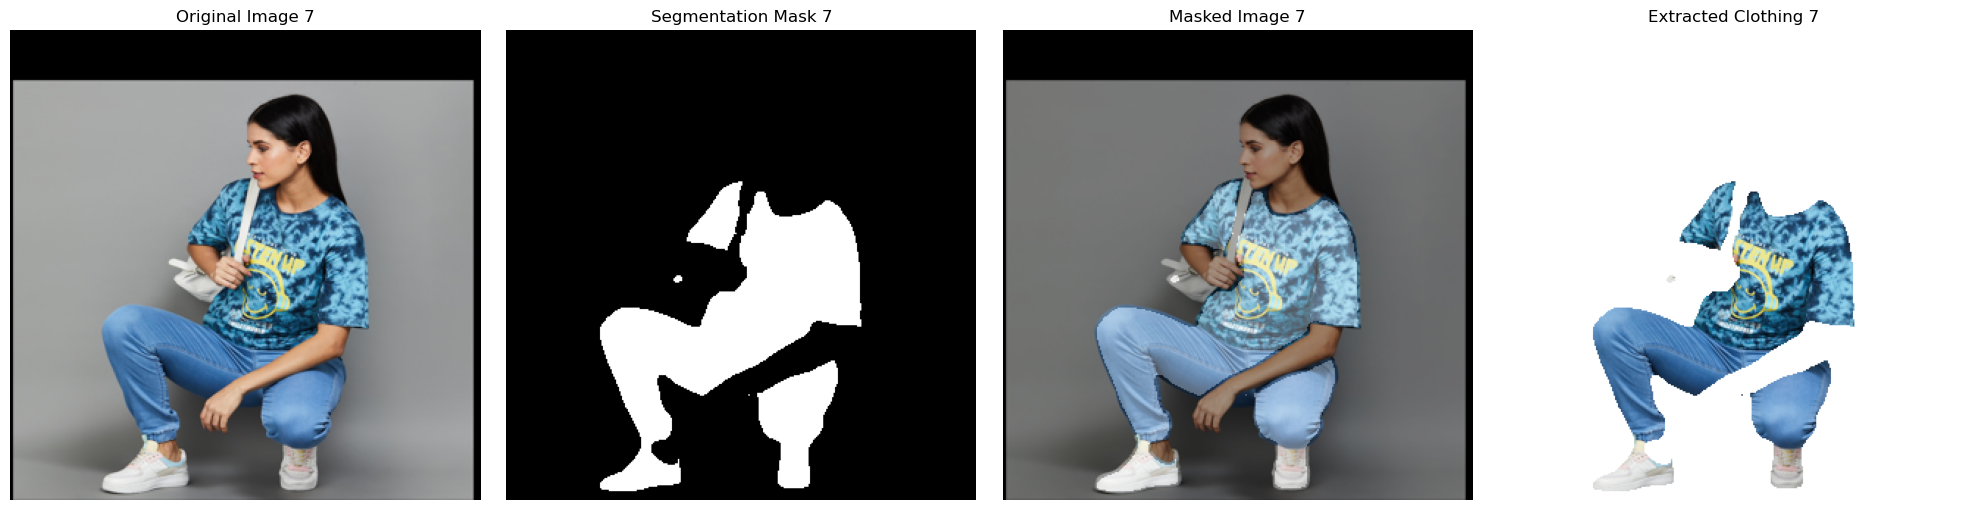

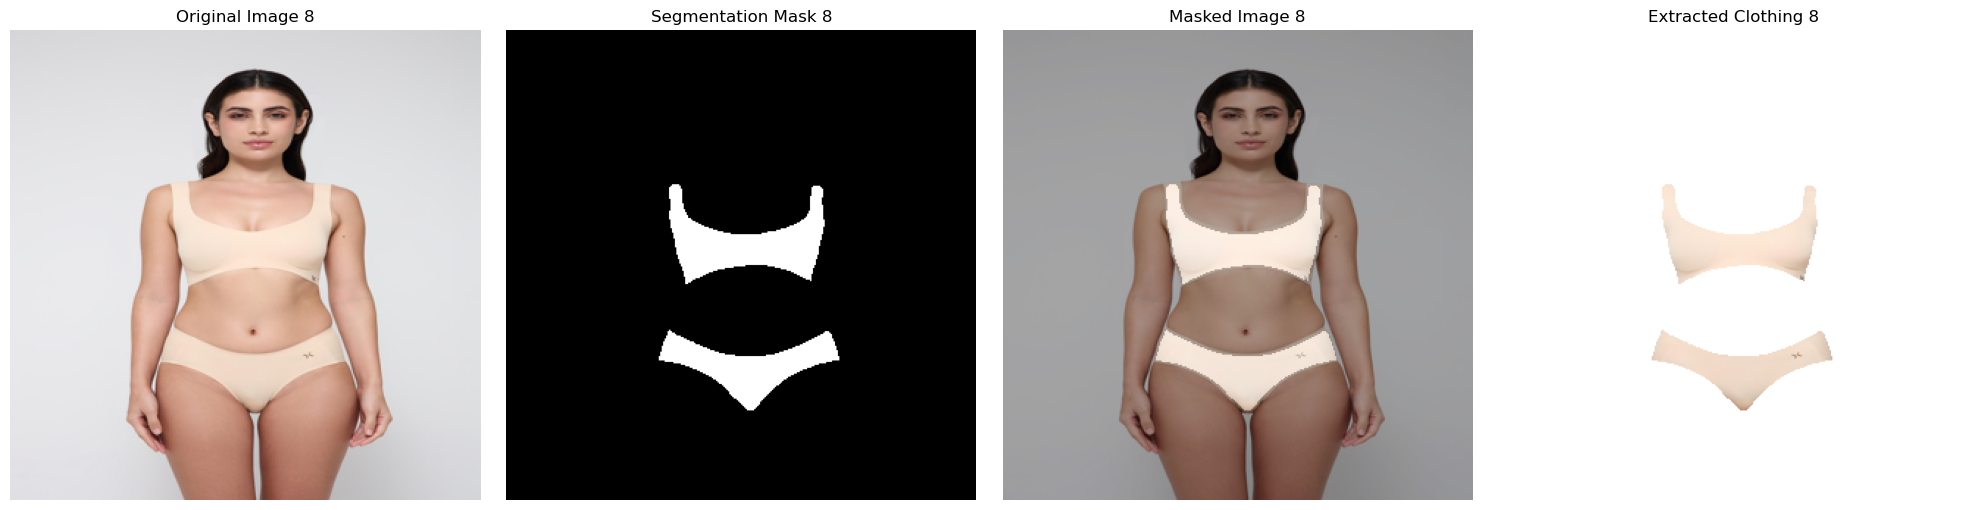

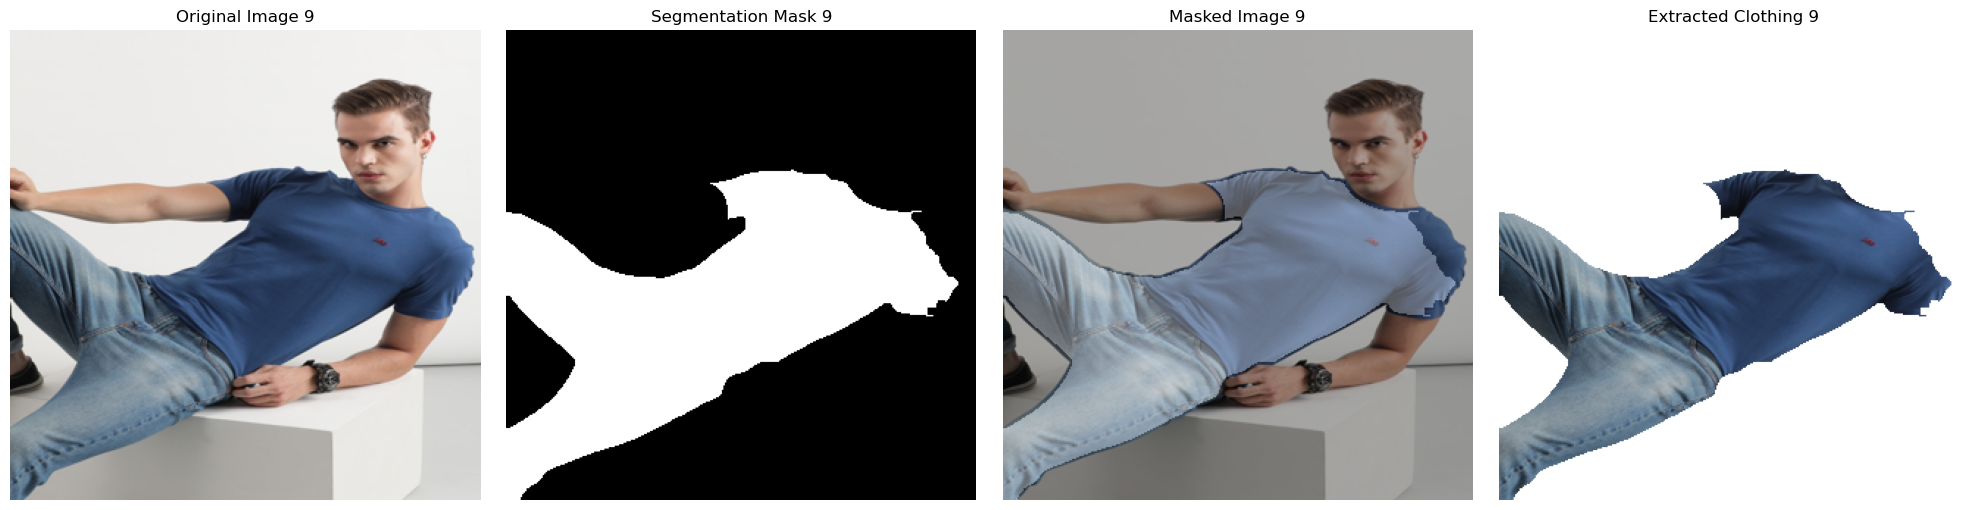

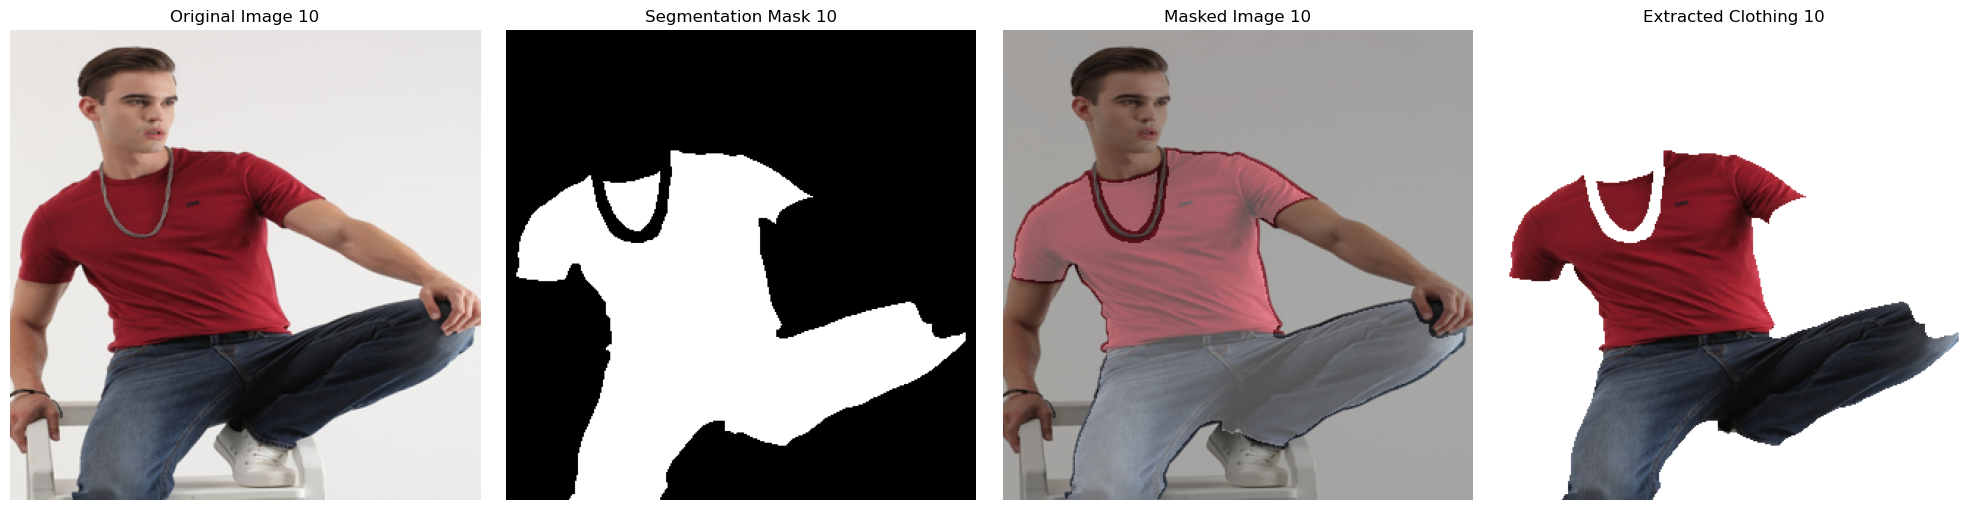

Segmentation results saved in: C:\Users\osyed\OneDrive\Desktop\AIML Assessment project\ClotheSegmentation\ClotheSegmentationOuput


In [37]:
if __name__ == "__main__":
    # Initialize the model
    model = create_model("Unet_2020-10-30").to(device)
    model.eval()

    # Define image paths
    image_paths = [
        r"C:\Users\osyed\OneDrive\Desktop\AIML Assessment project\Images\image_1.jpeg",
        r"C:\Users\osyed\OneDrive\Desktop\AIML Assessment project\Images\image_2.jpeg",
        r"C:\Users\osyed\OneDrive\Desktop\AIML Assessment project\Images\image_3.jpg",
        r"C:\Users\osyed\OneDrive\Desktop\AIML Assessment project\Images\image_4.jpg",
        r"C:\Users\osyed\OneDrive\Desktop\AIML Assessment project\Images\image_5.jpg",
        r"C:\Users\osyed\OneDrive\Desktop\AIML Assessment project\Images\image_6.jpg",
        r"C:\Users\osyed\OneDrive\Desktop\AIML Assessment project\Images\image_7.jpg",
        r"C:\Users\osyed\OneDrive\Desktop\AIML Assessment project\Images\image_8.jpg",
        r"C:\Users\osyed\OneDrive\Desktop\AIML Assessment project\Images\image_9.jpeg",
        r"C:\Users\osyed\OneDrive\Desktop\AIML Assessment project\Images\image_10.jpeg"
    ]

    # Define output directory
    output_dir = r"C:\Users\osyed\OneDrive\Desktop\AIML Assessment project\ClotheSegmentation\ClotheSegmentationOuput"

    # Process images
    process_images(image_paths, output_dir)